In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.max_columns', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
import csv
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.5)
import numpy as np
import importlib
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import CleanData, SaveState
importlib.reload(CleanData)
importlib.reload(SaveState)
from CleanData import clean_comment, get_bag_of_words

[nltk_data] Downloading package stopwords to /home/zchao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Get stopword list
stop_words = stopwords.words('english')
number_strs = ['one', 'two', 'three', 'four', 'five', 'six', 'seven',\
'eight', 'nine', 'ten']
stop_words.extend(number_strs)

In [3]:
# Load tweet from members
tweets_df = pd.read_csv('../data/news_outlets_50K.csv')
tweets_df = tweets_df[['user_screen_name', 'id', 'text', 'created_at']]
tweets_df = tweets_df.rename(columns={"user_screen_name": "user_name", "text": "clean_tweet"}) 

/home/zchao/FlowPredict/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Some media used as Left label:
# 'thinkprogress'(-20), 'MSNBC'(-20), thenation'(-17), 'thedailybeast'(-16), {'CNN', 'cnnbrk'}(-15), 
# 'MotherJones'(-15),
# Some media used as Right label:
# 'cnsnews'(26), 'foxnewsradio'(24), 'FDRLST'(23), 'BreitbartNews'(20), DailyCaller'(20),
# 'theblaze'(16), 'FoxNews'(15)
# Some neutral media:
# 'BBC'(-2), 'businessinsider'(-1), 'CBSNews'(-2), 'TheEconomist'(-3), 'thehill'(0), 'WSJ'(2),
# 'Independent'(?), 'ABC'(-1), etc.
# Some test media:
# 'AP'(associated press, -1), 'TheAtlantic'(-7), axios(-6), BBC(-3), 'BuzzFeed'(-8),
# 'DailySignal'(25), 'newrepublic'(-12), 'ForeignPolicy'(-2), 'TheIJR'(7), 'NRO'(15)
left_train_users = ['thinkprogress', 'MSNBC', 'thenation', 'thedailybeast', 'cnnbrk']

right_train_users = ['foxnewsradio', 'FDRLST','BreitbartNews', 'DailyCaller', 'theblaze', 'FoxNews']

neutral_test_users = ['BBC', 'businessinsider', 'CBSNews', 'TheEconomist', 'thehill', \
                      'WSJ','Independent','ABC', 'AP', 'ForeignPolicy']

left_test_users = ['CNN', 'newrepublic', 'TheAtlantic', 'axios', 'BuzzFeed', 'newrepublic', 'MotherJones']
right_test_users = ['cnsnews', 'DailySignal', 'TheIJR', 'NRO']

all_users = right_train_users+left_train_users+neutral_test_users+left_test_users+right_test_users

tweets_df = tweets_df.loc[tweets_df['user_name'].isin(all_users)]
# tweets_df.shape

In [5]:
import preprocessor as p
tweets_df['clean_tweet']  = tweets_df['clean_tweet'].apply(p.clean)
bag_of_words, vectorizer = get_bag_of_words(tweets_df['clean_tweet'],ngram_range=(1,3), min_df=0.001)
print(bag_of_words.shape)

(2514, 3300)


In [6]:
# Train binary multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics
def get_binary_NB_model(bag_of_words, df):
    # Training data:
    class1_words = bag_of_words[df['user_name'].isin(right_train_users),:]
    class2_words = bag_of_words[df['user_name'].isin(left_train_users),:]
    train_tweets = np.concatenate((class1_words,class2_words))
    labels = np.concatenate((np.zeros(class1_words.shape[0]),np.ones(class2_words.shape[0])))
    nb = ComplementNB()
    nb.fit(train_tweets, labels)
    # # Performance on training data
    predictions = nb.predict(train_tweets)
    print('Training Accuracy: ' + str(sum(labels==predictions)/len(labels)))
    # Compute the error.
    tn, fp, fn, tp = metrics.confusion_matrix(labels,predictions).ravel()
    print(tn, fp, fn, tp)
    return nb

In [7]:
nb_model = get_binary_NB_model(bag_of_words, tweets_df)

Training Accuracy: 0.9321789321789322
403 24 23 243


In [8]:
# predictions = nb_model.predict(bag_of_words[tweets_df['user_name'].isin(test_users),:])
# tweets_df['nb_tweet_pred'] = np.NaN
# tweets_df.loc[tweets_df['user_name'].isin(test_users),['nb_tweet_pred']] = predictions
predict_probs = nb_model.predict_proba(bag_of_words)
tweets_df['left_prob'] = predict_probs[:,0]
tweets_df['right_prob'] = predict_probs[:,1]
tweets_df['nb_tweet_pred'] = nb_model.predict(bag_of_words)

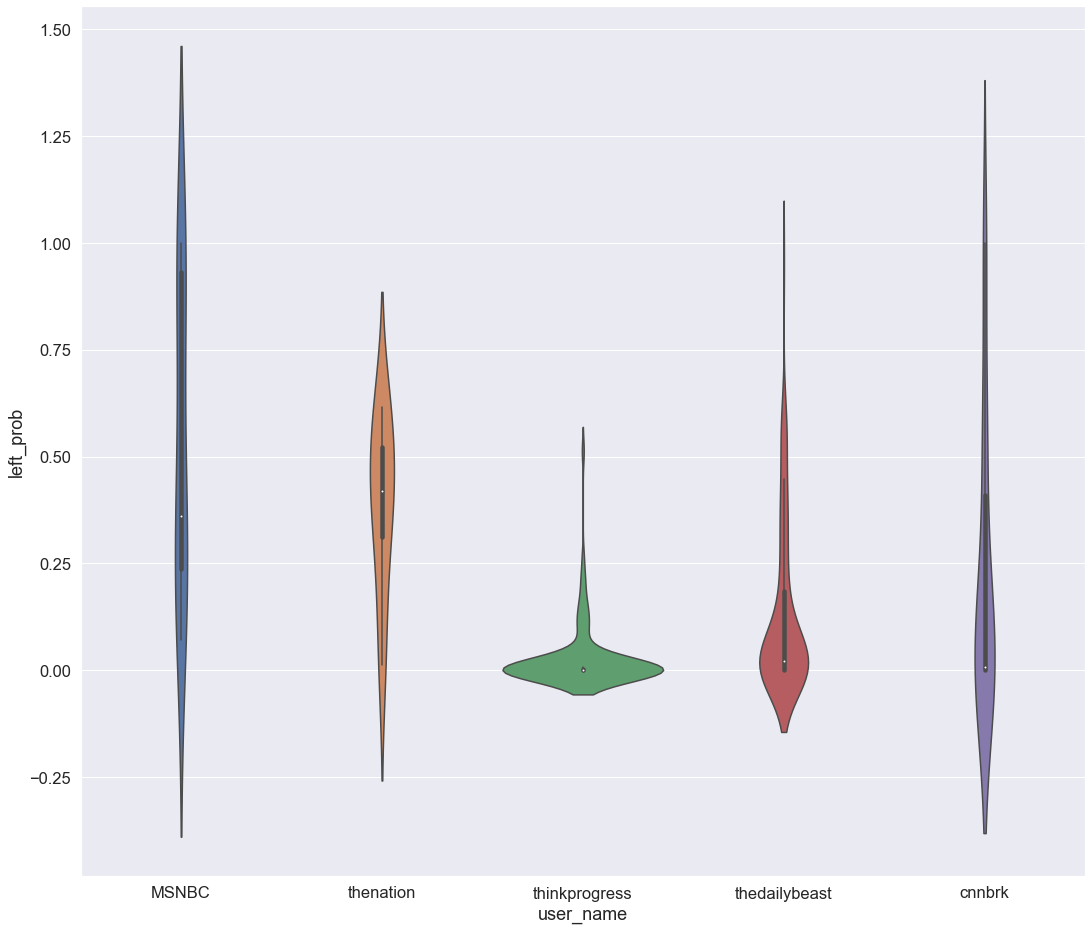

In [9]:
# Make scatter plots for train_left:
plt.figure(figsize=(18, 16))
sns.violinplot(x='user_name', y='left_prob', data=tweets_df.loc[tweets_df['user_name'].isin(left_train_users)])

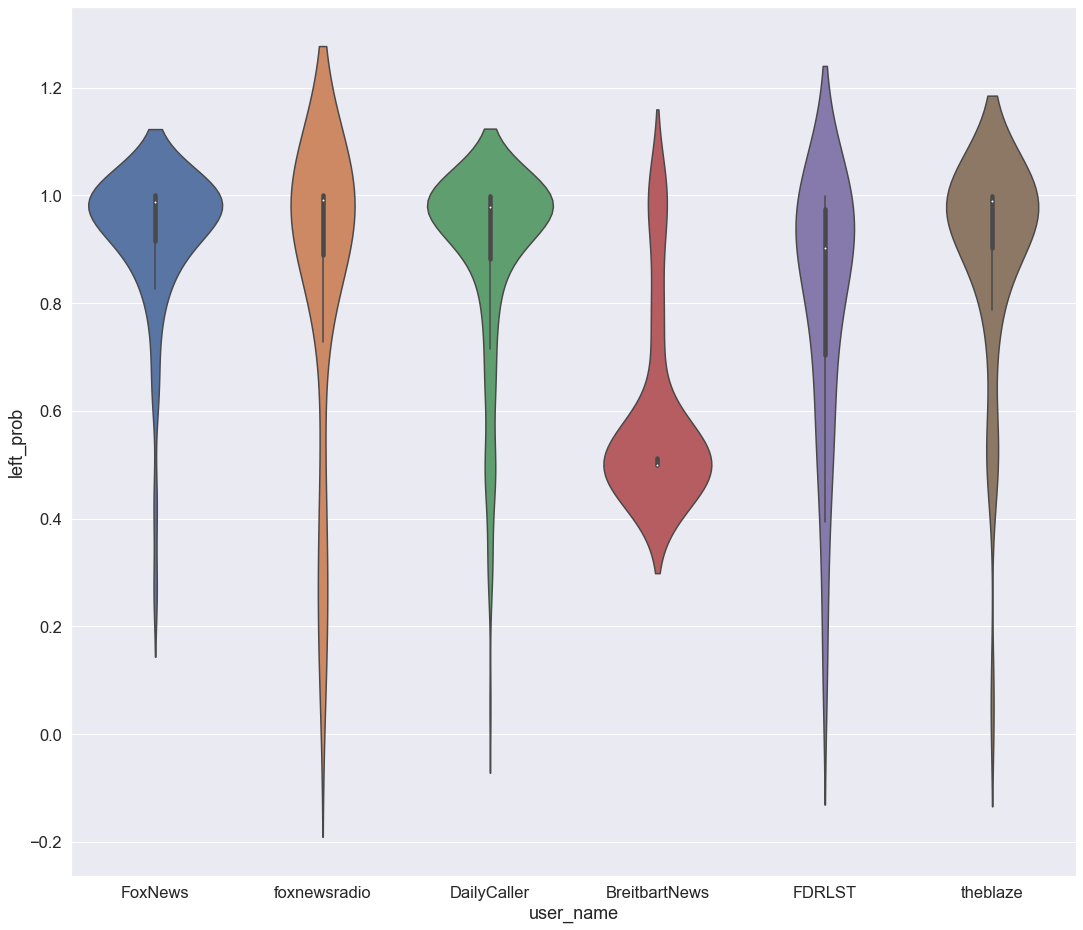

In [10]:
# Make scatter plots for train_right:
plt.figure(figsize=(18, 16))
sns.violinplot(x='user_name', y='left_prob', data=tweets_df.loc[tweets_df['user_name'].isin(right_train_users)])

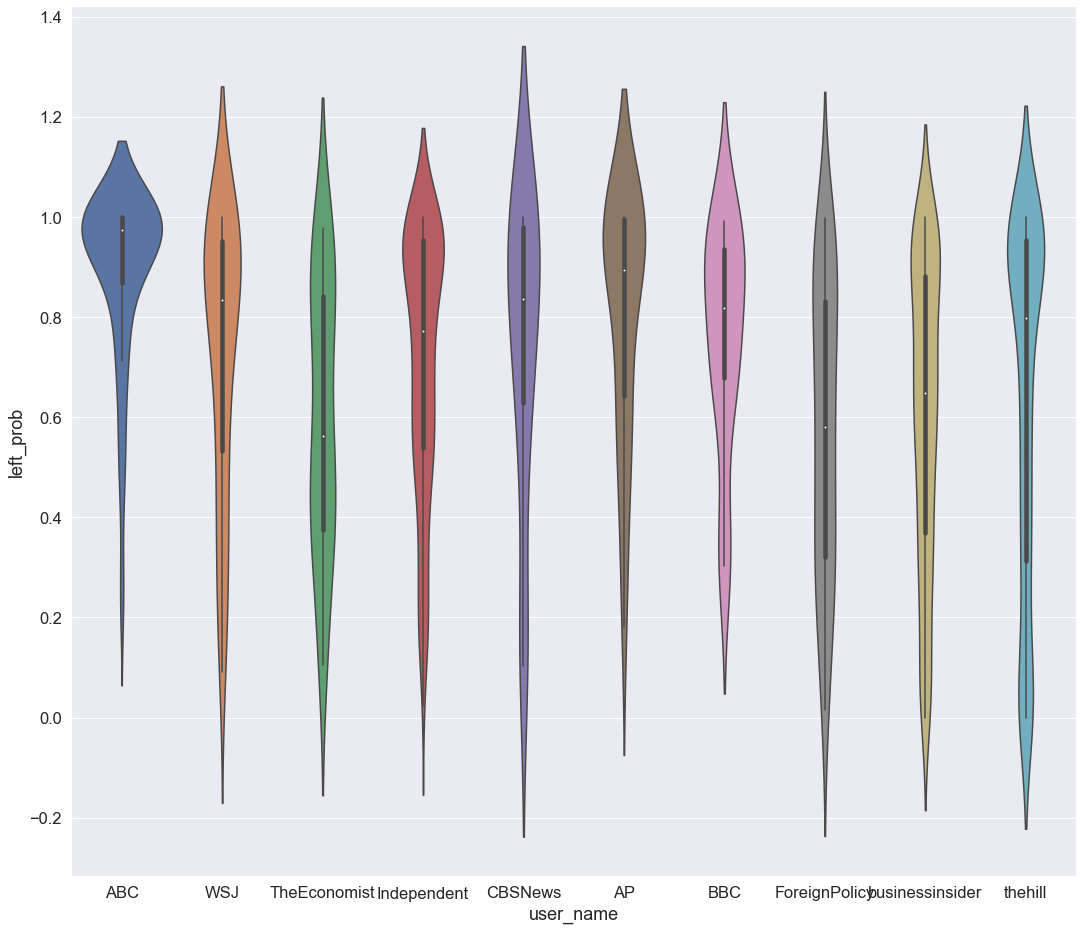

In [11]:
# Make scatter plots for test_neutral:
plt.figure(figsize=(18, 16))
sns.violinplot(x='user_name', y='left_prob', data=tweets_df.loc[tweets_df['user_name'].isin(neutral_test_users)])

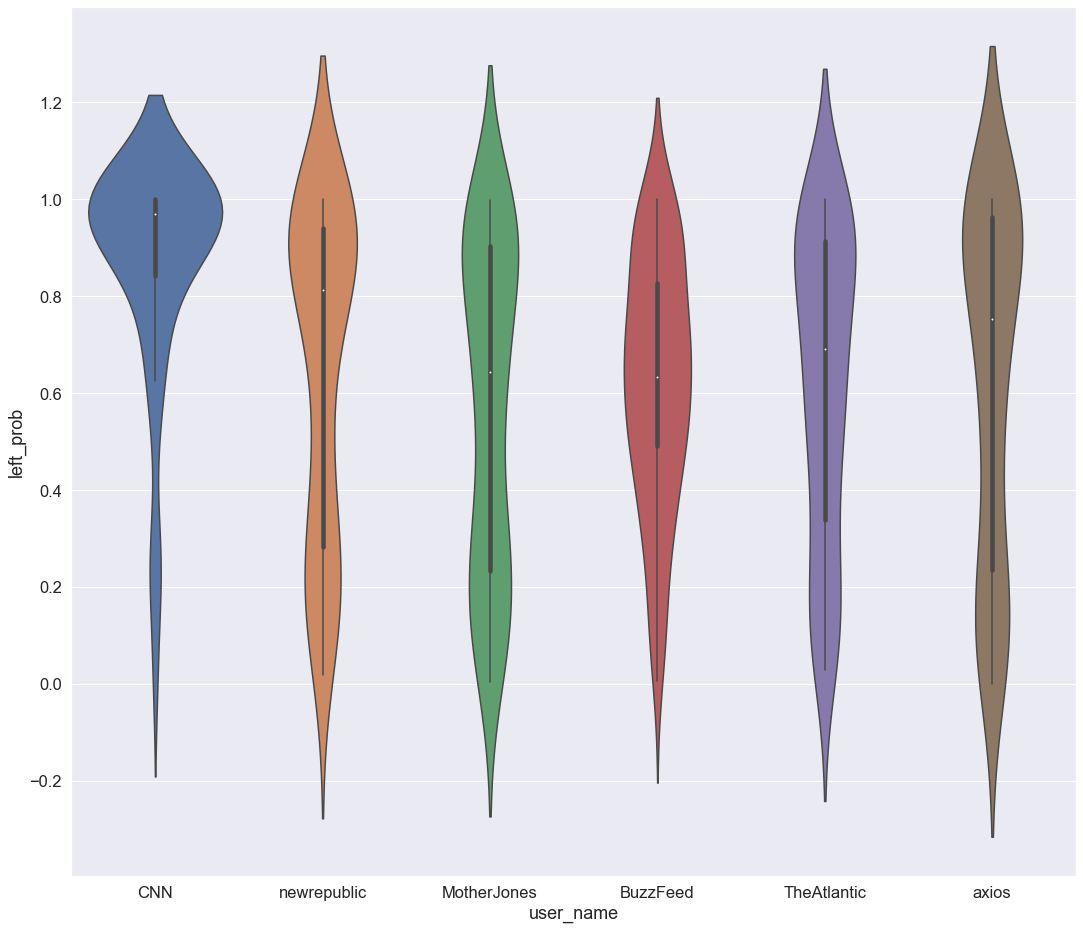

In [12]:
# Make scatter plots for test_left:
plt.figure(figsize=(18, 16))
sns.violinplot(x='user_name', y='left_prob', data=tweets_df.loc[tweets_df['user_name'].isin(left_test_users)])

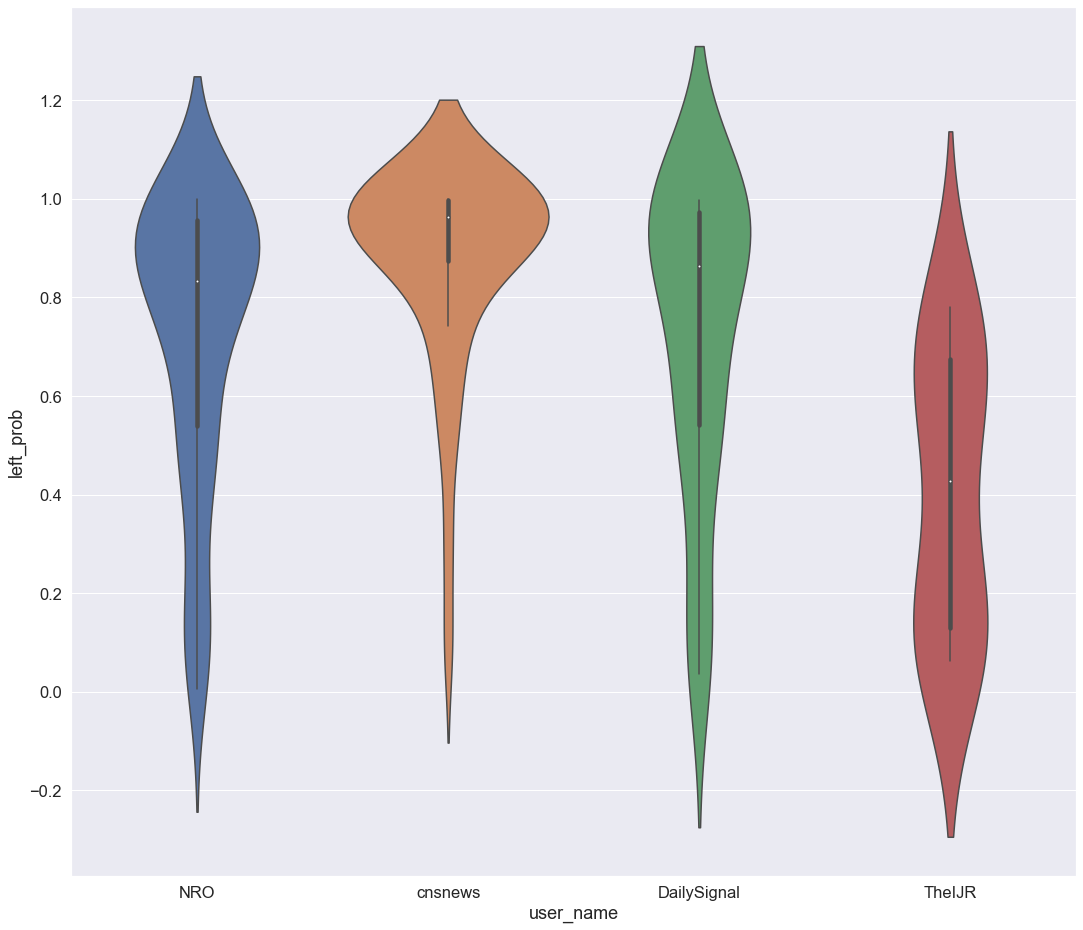

In [13]:
# Make scatter plots for test_right:
plt.figure(figsize=(18, 16))
sns.violinplot(x='user_name', y='left_prob', data=tweets_df.loc[tweets_df['user_name'].isin(right_test_users)])